## Definir funções utilitárias

In [1]:
def get_hidden_states(bert_model, tokenizer, text):
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    with torch.no_grad():
        outputs = bert_model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
        return hidden_states

In [2]:
def get_embeddings(text):
   
    hidden_states = get_hidden_states(bert_model, tokenizer, text)
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    
    return token_embeddings

# Carregar os embeddings

### com Pytorch

In [3]:
# import torch
# import numpy as np

# MODEL = 'NLI'
# MODEL_PATH = '../../models/' + MODEL + '/pytorch_model.bin'

# md = torch.load(MODEL_PATH ,map_location='cpu')

# embeds = []
# for k in md:
#     if (k == 'embeddings.word_embeddings.weight'):
#         embeds = md[k]
        
# X = np.array(embeds)

# words = []
# with open('../../models/' + MODEL + '/vocab.txt', "r") as f:
#     words = f.readlines()
    
# X_reduzido = X[12000:28125]
# words_reduzido = words[12000:28125]
# # X_reduzido = X
# # words_reduzido = words

# print("Tamanho: ",len(X_reduzido))

### com transformers

In [4]:
from transformers import BertTokenizer, BertModel

MODEL_PATH = 'fagner/envoy'
# MODEL_PATH = 'bert-base-cased'
# MODEL_PATH = 'dmis-lab/biobert-base-cased-v1.1'

tokenizer = BertTokenizer.from_pretrained(MODEL_PATH, do_lower_case=False)
model = BertModel.from_pretrained(MODEL_PATH)

embeds = model.state_dict()['embeddings.word_embeddings.weight'] 

words = list(tokenizer.vocab.keys())

X_reduzido = embeds[12000:28125]
words_reduzido = words[12000:28125]

print('Tamanho: ',len(words_reduzido))

# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())  


Some weights of the model checkpoint at fagner/envoy were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at fagner/envoy and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tamanho:  16125


# Clusterização

### Funções pro plot

In [13]:
from matplotlib import pyplot as plt
import os

IMG_PATH = 'imgs/'

if not os.path.exists(IMG_PATH):
    os.mkdir(IMG_PATH)

def plot_clustering(X_red, labels, title=None):
    plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 8))
    print(X_red)
    for i in range(X_red.shape[0]):
#         print(X_red[i, 0])
#         print(X_red[i, 1])
        plt.text(X_red[i, 0], X_red[i, 1], str(words_reduzido[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(IMG_PATH + title)

In [6]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    IMG_NAME = MODEL_PATH.replace('/', "-").replace('.', "-")

    plt.savefig(IMG_PATH + IMG_NAME + '-dendrograma')

In [7]:
from time import time
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold

clustering = AgglomerativeClustering(linkage='ward', distance_threshold=7, n_clusters=None)
t0 = time()
model = clustering.fit(X_reduzido)
print(model)
print("%s :\t%.2fs" % ('Duração: ', time() - t0))

AgglomerativeClustering(distance_threshold=7, n_clusters=None)
Duração:  :	54.99s


In [8]:
from sklearn import manifold

X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X_reduzido)

fagner-envoy
[[0.59341486 0.07463592]
 [0.1227381  0.11163258]
 [0.33739284 0.14636176]
 ...
 [0.06505288 0.08553437]
 [0.08243408 0.04998318]
 [0.08244536 0.11435512]]


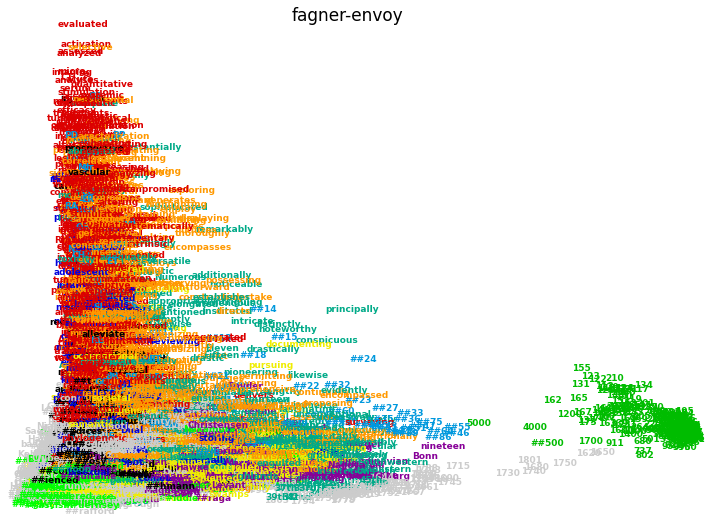

In [14]:
IMG_NAME = MODEL_PATH.replace('/', "-").replace('.', "-")
print(IMG_NAME)
plot_clustering(X_red, clustering.labels_, IMG_NAME)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sans TW, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sans TW, sans-serif


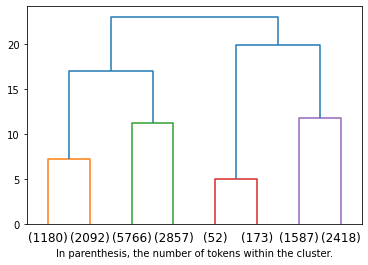

In [10]:
plot_dendrogram(model, truncate_mode='level', p=2)
plt.xlabel("In parenthesis, the number of tokens within the cluster.")
plt.show()


In [11]:
len(set(model.labels_))

13